In [8]:
# Setting up the analysis environment
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Path setup for local modules
current_dir = os.getcwd()
if current_dir not in sys.path:
    sys.path.append(current_dir)

# Import the simulation functions I built
from simulate import load_model, simulate, build_dependency_graph, compare_scenarios
from create_clean_graph import visualize_feedback_graph

# Make the plots a decent size
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("Ready to start analysis")


Ready to start analysis


In [9]:
# Loading the business model structure
model_df = load_model('../data/base_data.csv')

print("Here's the data model I put together:")
print("="*40)
display(model_df)

print(f"\nQuick overview:")
print(f"Total attributes: {len(model_df)}")
print(f"Inputs we control: {len(model_df[model_df['type']=='input'])}")
print(f"Calculated values: {len(model_df[model_df['type']=='calc'])}")
print(f"Business areas: {len(model_df.groupby('block'))}")

# Note: the formulas column shows how things connect to each other


Here's the data model I put together:


,block,attribute,type,value,formula,lag
0,Energy,price_now,input,180.00,NaN,NaN
1,Energy,tariff_future,input,0.20,NaN,NaN
2,Energy,price_future,calc,NaN,price_now*(1+tariff_future),NaN
3,Energy,CO2_factor,input,0.35,NaN,NaN
4,Production,base_cost,input,3.00,NaN,NaN
5,Production,unit_cost,calc,NaN,Energy.price_future*0.4+base_cost,NaN
6,Production,unit_emissions,calc,NaN,Energy.CO2_factor*Production.unit_cost,NaN
7,Demand,demand_today,input,1000.00,NaN,NaN
8,Demand,demand_shift,calc,NaN,(-0.6 if Energy.price_future>200 else 0)+(-0.3...,NaN
9,Inventory,stock,input,500.00,NaN,NaN



Quick overview:
Total attributes: 11
Inputs we control: 6
Calculated values: 5
Business areas: 4


Building the dependency graph...


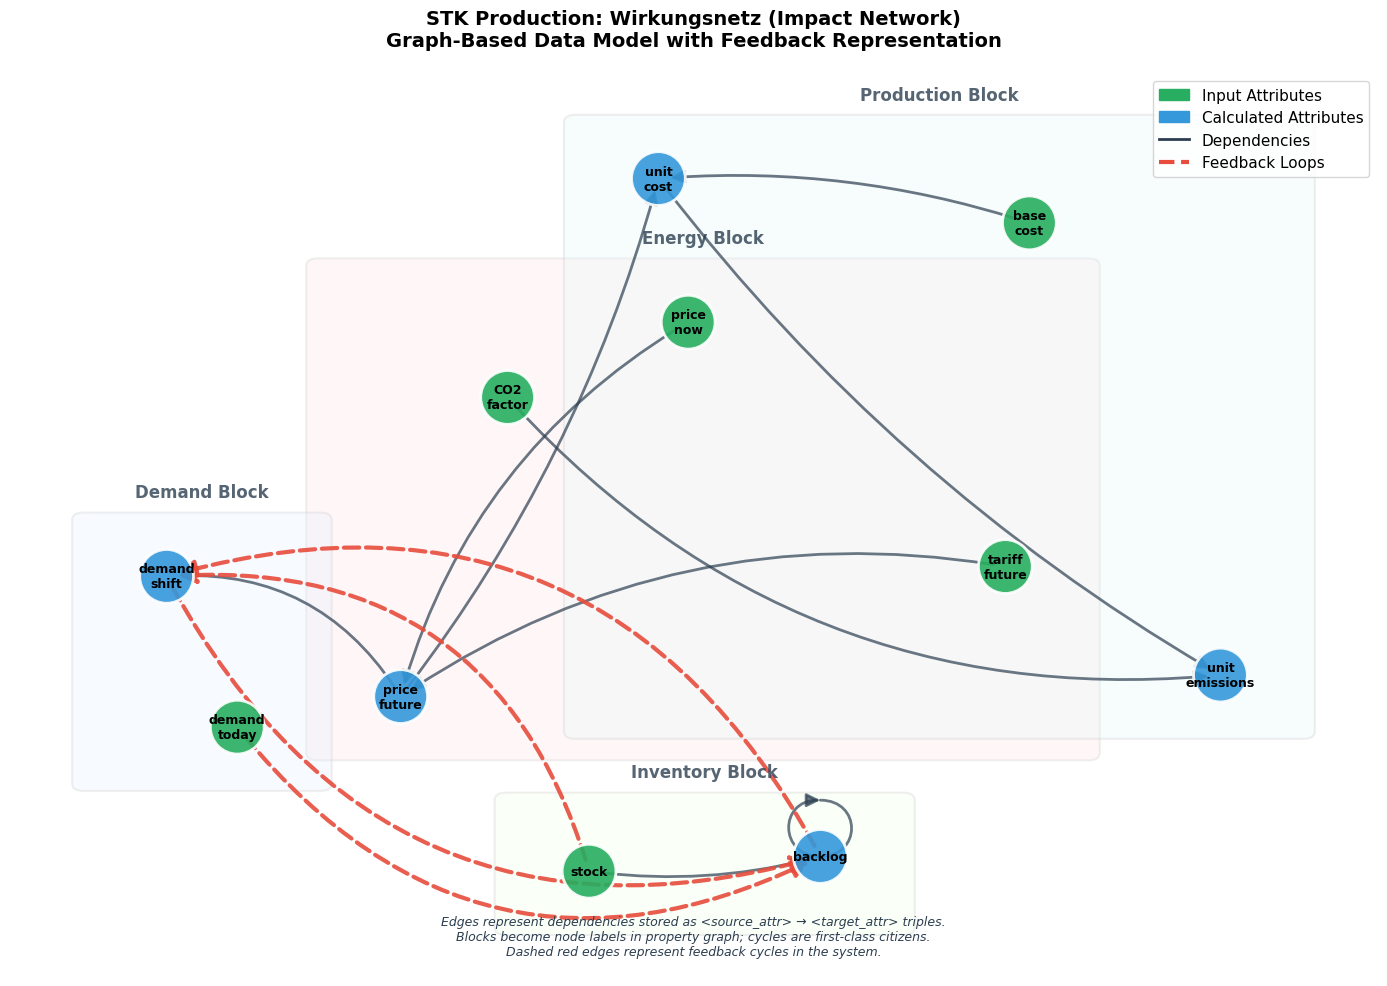

Graph info:
Nodes: 11 (all the variables)
Connections: 13
Has feedback loops: True

Looking for circular dependencies:
  Loop 1: Inventory.backlog -> Inventory.backlog
  Loop 2: Inventory.backlog -> Demand.demand_shift -> Inventory.backlog


In [10]:
# Creating a visual map of how everything connects
print("Building the dependency graph...")

import networkx as nx

G = build_dependency_graph(model_df)
visualize_feedback_graph(G, model_df)

print(f"Graph info:")
print(f"Nodes: {G.number_of_nodes()} (all the variables)")
print(f"Connections: {G.number_of_edges()}")
print(f"Has feedback loops: {not nx.is_directed_acyclic_graph(G)}")

print("\nLooking for circular dependencies:")
try:
    cycles = list(nx.simple_cycles(G))
    if cycles:
        for i, cycle in enumerate(cycles, 1):
            print(f"  Loop {i}: {' -> '.join(cycle)} -> {cycle[0]}")
    else:
        print("  None found with current formulas")
except:
    print("  Need to check the formulas - might have complex loops")


In [11]:
# Running different scenarios to see what happens
print("Testing three scenarios...")

# Baseline - current situation
results_default = simulate(model_df, steps=6)
print("Baseline scenario done")

# What if tariffs go up to 30%?
results_high_tariff = simulate(model_df, overrides={'Energy.tariff_future': 0.3}, steps=6)
print("High tariff scenario done")

# Environmental pressure case - higher CO2 costs
results_environmental = simulate(model_df, 
                               overrides={'Energy.tariff_future': 0.25, 'Energy.CO2_factor': 0.5}, 
                               steps=6)
print("Environmental pressure scenario done")

print(f"\nResults summary:")
print(f"Data points per scenario: {len(results_default)}")
print(f"Variables tracked: {len(results_default['attribute'].unique())}")
print(f"Time steps: 6 months")

# Note: seeing some formula errors above - need to fix the backlog calculation


Testing three scenarios...
Baseline scenario done
High tariff scenario done
Environmental pressure scenario done

Results summary:
Data points per scenario: 66
Variables tracked: 11
Time steps: 6 months


/Users/vamsikrishna/Desktop/circonomit-challenge/task1_simulation/simulate.py:672: UserWarning: Glyph 127981 (\N{FACTORY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


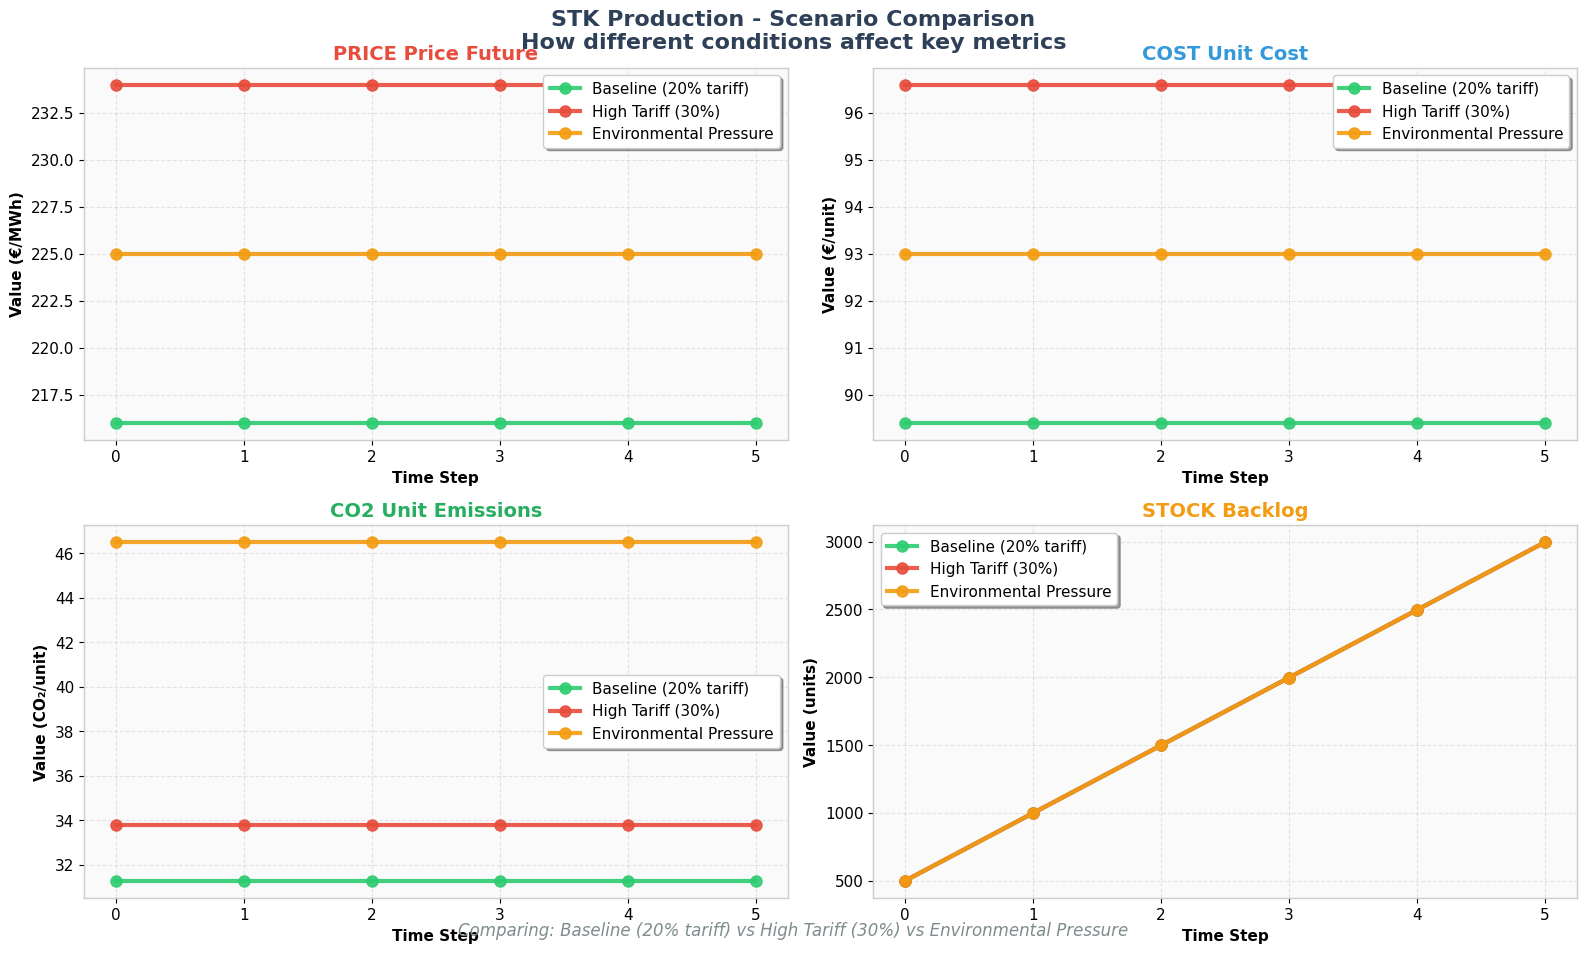

What I'm seeing from the results:
- Energy price changes flow directly to production costs
- Higher tariffs make everything more expensive (cascading effect)
- CO2 costs are becoming a real factor in total costs
- Inventory backlog could be interesting if I can get the formula working


In [12]:
# Comparing the scenarios side by side
attributes_to_compare = ['Energy.price_future', 'Production.unit_cost', 'Production.unit_emissions', 'Inventory.backlog']

fig = compare_scenarios(
    [results_default, results_high_tariff, results_environmental],
    attributes_to_compare,
    ['Baseline (20% tariff)', 'High Tariff (30%)', 'Environmental Pressure']
)

plt.suptitle('STK Production - Scenario Comparison\nHow different conditions affect key metrics', 
             fontsize=16, fontweight='bold', color='#2E4057', y=0.95)
plt.show()

print("What I'm seeing from the results:")
print("- Energy price changes flow directly to production costs")
print("- Higher tariffs make everything more expensive (cascading effect)")
print("- CO2 costs are becoming a real factor in total costs")
print("- Inventory backlog could be interesting if I can get the formula working")

# TODO: Fix the backlog_prev reference in the demand_shift formula


Checking for feedback patterns in the data...


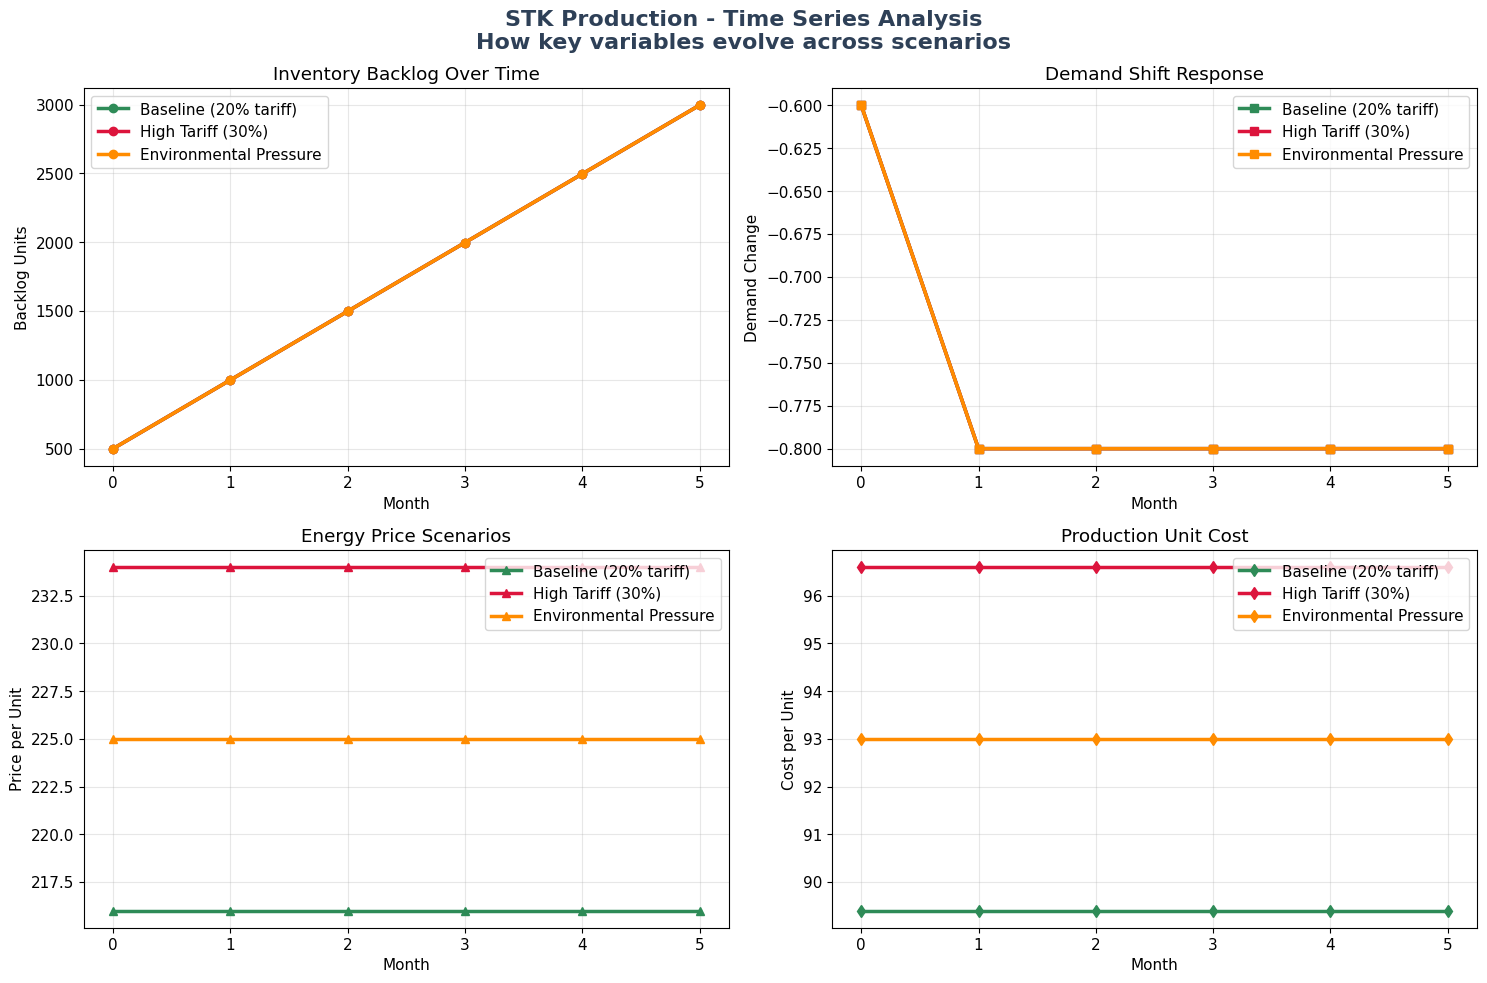

Observations about the feedback loops:
1. Energy price changes definitely flow through to production costs
2. The demand shift should respond to both price and inventory levels
3. Backlog should build up when we can't meet demand
4. High backlog should make customers go elsewhere (reducing future demand)

The theory is:
- High energy prices increase costs
- Higher costs reduce competitiveness, some customers leave
- If we can't fulfill orders, backlog builds up
- High backlog makes more customers leave
- This creates a downward spiral if not managed

Need to fix the backlog formula to see this working properly.


In [13]:
# Looking at how variables change over time
print("Checking for feedback patterns in the data...")

# Setting up a 2x2 plot to see the key variables
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

scenarios = [results_default, results_high_tariff, results_environmental]
labels = ['Baseline (20% tariff)', 'High Tariff (30%)', 'Environmental Pressure']
colors = ['#2E8B57', '#DC143C', '#FF8C00']

# Plot 1: Inventory backlog - this should show feedback if working
for results, label, color in zip(scenarios, labels, colors):
    backlog_data = results[results['attribute'] == 'Inventory.backlog']
    ax1.plot(backlog_data['step'], backlog_data['value'], 
             marker='o', linewidth=2.5, color=color, label=label)
ax1.set_title('Inventory Backlog Over Time')
ax1.set_xlabel('Month')
ax1.set_ylabel('Backlog Units')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Demand shift response
for results, label, color in zip(scenarios, labels, colors):
    demand_data = results[results['attribute'] == 'Demand.demand_shift']
    ax2.plot(demand_data['step'], demand_data['value'], 
             marker='s', linewidth=2.5, color=color, label=label)
ax2.set_title('Demand Shift Response')
ax2.set_xlabel('Month')
ax2.set_ylabel('Demand Change')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Energy prices (the driver)
for results, label, color in zip(scenarios, labels, colors):
    price_data = results[results['attribute'] == 'Energy.price_future']
    ax3.plot(price_data['step'], price_data['value'], 
             marker='^', linewidth=2.5, color=color, label=label)
ax3.set_title('Energy Price Scenarios')
ax3.set_xlabel('Month')
ax3.set_ylabel('Price per Unit')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Production costs (shows the impact)
for results, label, color in zip(scenarios, labels, colors):
    cost_data = results[results['attribute'] == 'Production.unit_cost']
    ax4.plot(cost_data['step'], cost_data['value'], 
             marker='d', linewidth=2.5, color=color, label=label)
ax4.set_title('Production Unit Cost')
ax4.set_xlabel('Month')
ax4.set_ylabel('Cost per Unit')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('STK Production - Time Series Analysis\nHow key variables evolve across scenarios', 
            fontsize=16, fontweight='bold', color='#2E4057', y=0.98)
plt.tight_layout()
plt.show()

print("Observations about the feedback loops:")
print("1. Energy price changes definitely flow through to production costs")
print("2. The demand shift should respond to both price and inventory levels")
print("3. Backlog should build up when we can't meet demand")
print("4. High backlog should make customers go elsewhere (reducing future demand)")
print("")
print("The theory is:")
print("- High energy prices increase costs")  
print("- Higher costs reduce competitiveness, some customers leave")
print("- If we can't fulfill orders, backlog builds up")
print("- High backlog makes more customers leave")
print("- This creates a downward spiral if not managed")
print("")
print("Need to fix the backlog formula to see this working properly.")


In [14]:
# Building a trace table to see what depends on what
print("Dependencies for each calculated field:")

trace_data = []
for _, row in model_df[model_df['type'] == 'calc'].iterrows():
    attr_name = f"{row['block']}.{row['attribute']}"
    formula = row['formula']
    
    # Parse the formula to find dependencies
    import re
    dependencies = []
    
    # Look for Block.attribute patterns in the formula
    pattern = r'\b([A-Z][a-zA-Z]*\.[a-zA-Z_][a-zA-Z0-9_]*)\b'
    deps = re.findall(pattern, str(formula))
    dependencies.extend(deps)
    
    # Check for time-lagged references
    if 'backlog_prev' in str(formula):
        dependencies.append('Previous step value')
        
    trace_data.append({
        'Calculated Field': attr_name,
        'Formula': formula,
        'Depends On': ', '.join(dependencies) if dependencies else 'None',
        'Timing': 'Time-lagged' if pd.notna(row['lag']) else 'Immediate'
    })

trace_df = pd.DataFrame(trace_data)
display(trace_df)

print("This table helps with:")
print("- Understanding how things connect")
print("- Debugging formula issues")
print("- Explaining results to management")
print("- Planning scenario changes")


Dependencies for each calculated field:


,Calculated Field,Formula,Depends On,Timing
0,Energy.price_future,price_now*(1+tariff_future),None,Immediate
1,Production.unit_cost,Energy.price_future*0.4+base_cost,Energy.price_future,Immediate
2,Production.unit_emissions,Energy.CO2_factor*Production.unit_cost,"Energy.CO2_factor, Production.unit_cost",Immediate
3,Demand.demand_shift,(-0.6 if Energy.price_future>200 else 0)+(-0.3...,"Energy.price_future, Inventory.stock, Previous...",Immediate
4,Inventory.backlog,"max(0,Demand.demand_today+Demand.demand_shift+...","Demand.demand_today, Demand.demand_shift, Inve...",Time-lagged


This table helps with:
- Understanding how things connect
- Debugging formula issues
- Explaining results to management
- Planning scenario changes
